Downloading...
From: https://drive.google.com/uc?id=1LLTrZiCAuPTpQUNWKVteyZzcJ-Zews6x
To: /content/cattle_weights.csv
100%|██████████| 169k/169k [00:00<00:00, 69.5MB/s]


Dataset downloaded successfully!
Shape: (1283, 22)
Columns: ['Concatenate', 'Year', 'Pasture', 'Treatment', 'Allocation.number', 'Type', 'Owner', 'Tag.Color', 'Tag', 'QAQC.Notes', 'Actual.on.date', 'Actual.off.date', 'Season.on.date', 'Season.off.date', 'Season.Days', 'on_Weight', 'on_Shrink', 'off_Weight', 'off_Shrink', 'Gain_shrunk', 'ADG_shrunk', 'Use.Flag']
   Year Pasture Treatment  on_Weight  off_Weight  Gain_shrunk  Season.Days
0  2000     15E  moderate        598         774        176.0           81
1  2000     15E  moderate        732         864        132.0           81
2  2000     15E  moderate        702         848        146.0           81
3  2000     15E  moderate        534         696        162.0           81
4  2000     15E  moderate        588         750        162.0           81
Final features: ['on_Weight', 'Season.Days', 'Year', 'treatment_encoded', 'pasture_encoded']
Target: Gain_shrunk (lbs) → Mean gain: 263.4 lbs


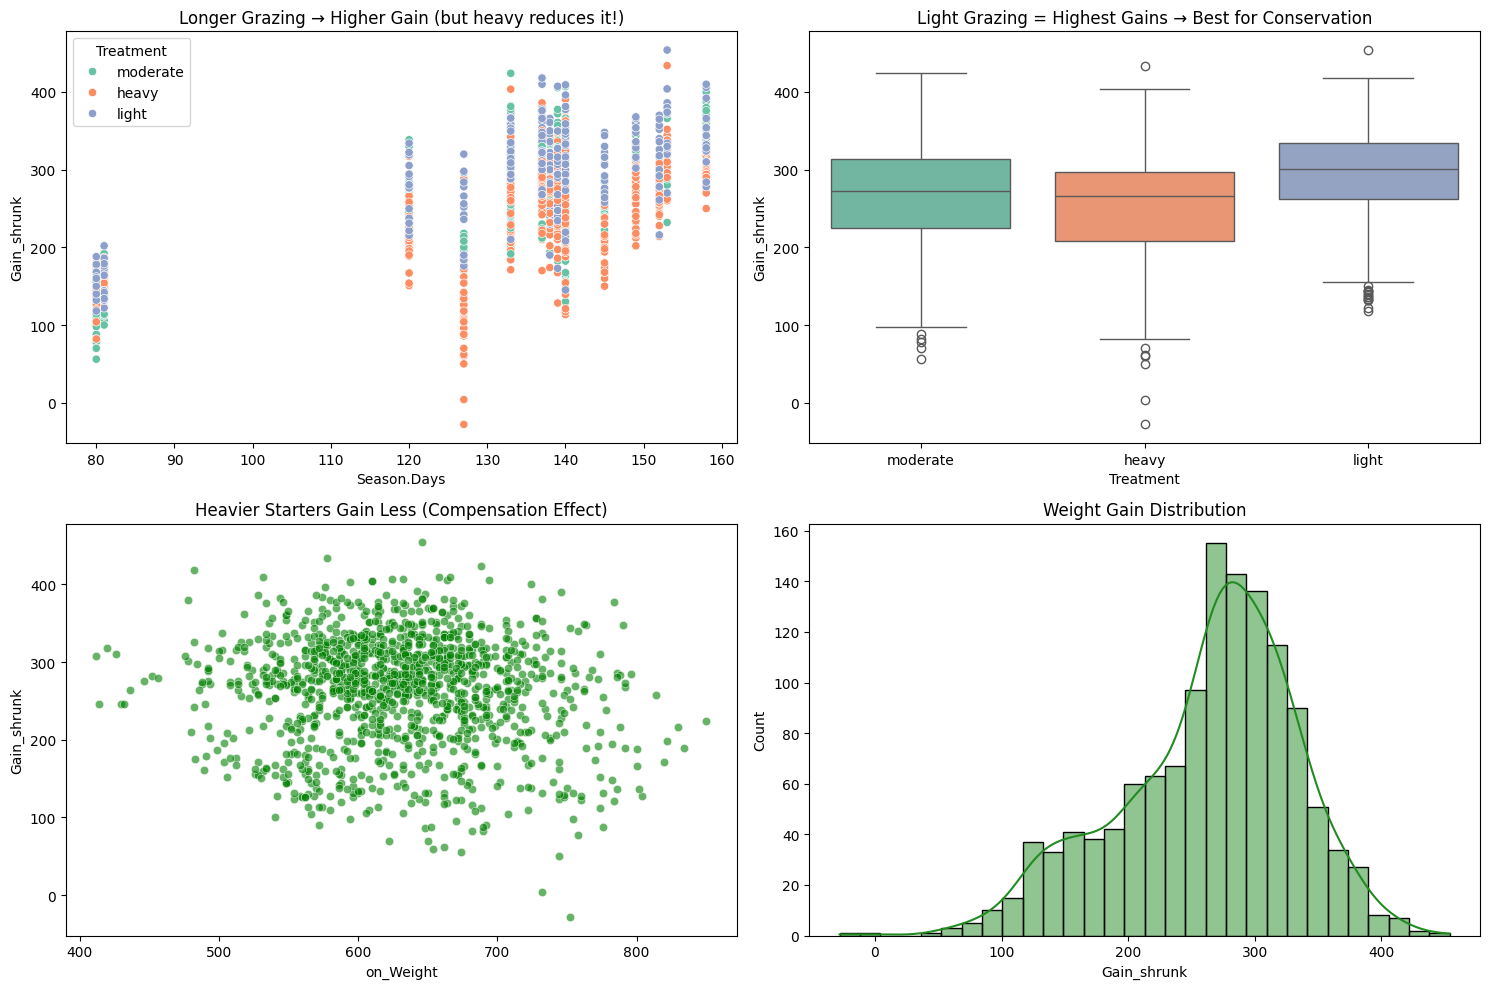

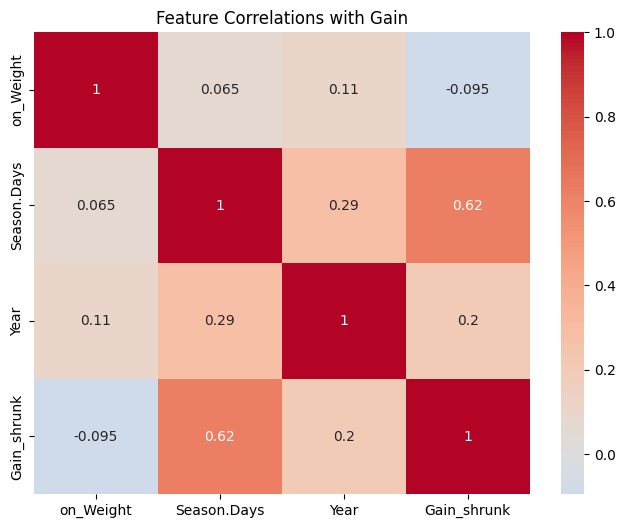

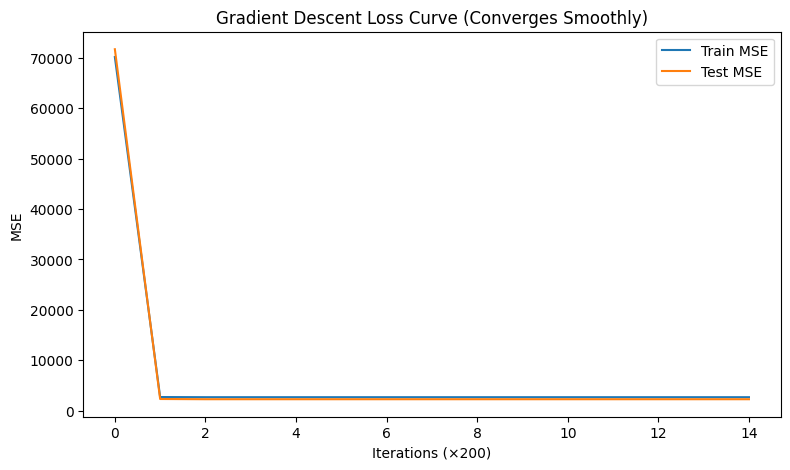

Linear Regression    → MSE: 2296.4 | R²: 0.4556
SGD Regressor        → MSE: 2300.0 | R²: 0.4547
Decision Tree        → MSE: 2980.5 | R²: 0.2934
Random Forest        → MSE: 1807.5 | R²: 0.5715

Best model (Random Forest) saved!


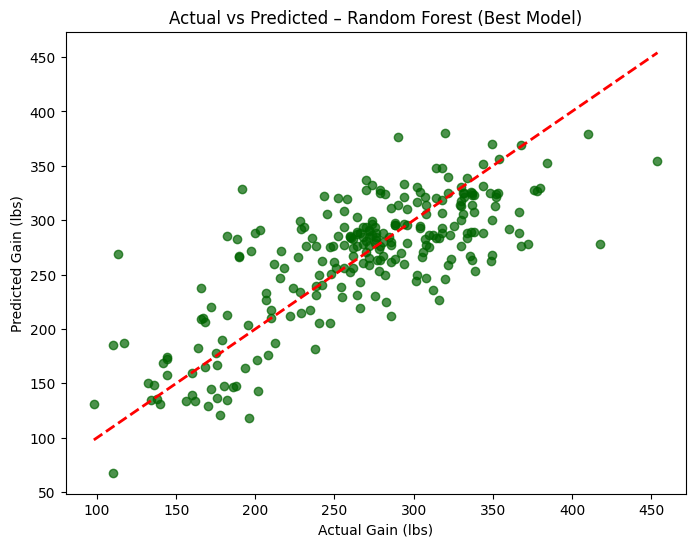

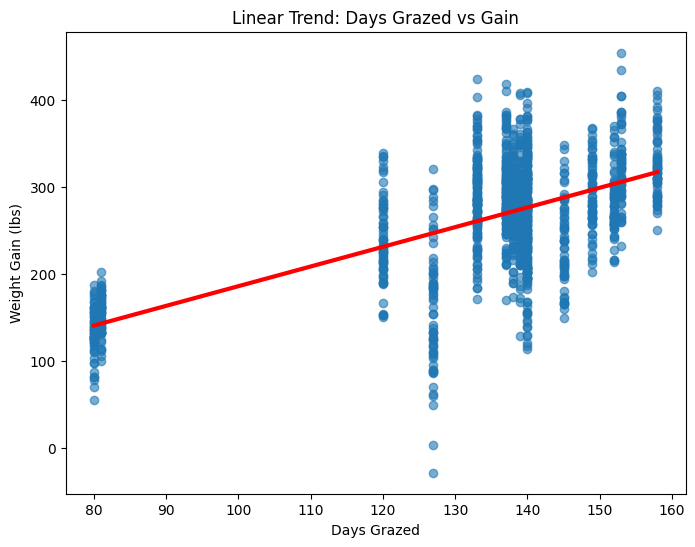

TASK 1 COMPLETE – All files ready for API!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
import os # Import the os module
warnings.filterwarnings('ignore')

# === 1. Downloading my exact dataset from my drive ===
try:
    import gdown
    gdown.download('https://drive.google.com/uc?id=1LLTrZiCAuPTpQUNWKVteyZzcJ-Zews6x', 'cattle_weights.csv', quiet=False)
    print("Dataset downloaded successfully!")
except:
    print("gdown failed — make sure file is shared publicly or place manually")

# === 2. Load & Inspect ===
df = pd.read_csv('cattle_weights.csv')
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist())
print(df[['Year', 'Pasture', 'Treatment', 'on_Weight', 'off_Weight', 'Gain_shrunk', 'Season.Days']].head())

# === 3. Feature Engineering  ===
df_clean = df.copy()

# Target
y = df_clean['Gain_shrunk']

# Features
df_clean['Treatment'] = df_clean['Treatment'].str.lower()
le_treatment = LabelEncoder()
df_clean['treatment_encoded'] = le_treatment.fit_transform(df_clean['Treatment'])

le_pasture = LabelEncoder()
df_clean['pasture_encoded'] = le_pasture.fit_transform(df_clean['Pasture'])

X = df_clean[[
    'on_Weight',      # initial weight
    'Season.Days',    # days grazed
    'Year',
    'treatment_encoded',
    'pasture_encoded'
]]

feature_names = ['on_Weight', 'Season.Days', 'Year', 'treatment_encoded', 'pasture_encoded']
print(f"Final features: {feature_names}")
print(f"Target: Gain_shrunk (lbs) → Mean gain: {y.mean():.1f} lbs")

# === 4. Visualizations (Beautiful & Interpretable) ===
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.scatterplot(x='Season.Days', y='Gain_shrunk', hue='Treatment', data=df_clean, palette='Set2')
plt.title('Longer Grazing → Higher Gain (but heavy reduces it!)')

plt.subplot(2,2,2)
sns.boxplot(x='Treatment', y='Gain_shrunk', data=df_clean, palette='Set2')
plt.title('Light Grazing = Highest Gains → Best for Conservation')

plt.subplot(2,2,3)
sns.scatterplot(x='on_Weight', y='Gain_shrunk', data=df_clean, alpha=0.6, color='green')
plt.title('Heavier Starters Gain Less (Compensation Effect)')

plt.subplot(2,2,4)
sns.histplot(y, kde=True, bins=30, color='forestgreen')
plt.title('Weight Gain Distribution')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df_clean[['on_Weight', 'Season.Days', 'Year', 'Gain_shrunk']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations with Gain')
plt.show()

# === 5. Standardization ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === 6. Gradient Descent from Scratch ===
X_train_b = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_b = np.c_[np.ones(X_test.shape[0]), X_test]
theta = np.random.randn(X_train_b.shape[1])
lr = 0.01
n_iters = 3000
m = len(y_train)
train_losses, test_losses = [], []

for i in range(n_iters):
    gradients = (2/m) * X_train_b.T.dot(X_train_b.dot(theta) - y_train)
    theta -= lr * gradients
    if i % 200 == 0:
        train_pred = X_train_b.dot(theta)
        test_pred = X_test_b.dot(theta)
        train_losses.append(mean_squared_error(y_train, train_pred))
        test_losses.append(mean_squared_error(y_test, test_pred))

plt.figure(figsize=(9,5))
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses, label='Test MSE')
plt.title('Gradient Descent Loss Curve (Converges Smoothly)')
plt.xlabel('Iterations (×200)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# === 7. All Models ===
models = {
    "Linear Regression": LinearRegression(),
    "SGD Regressor": SGDRegressor(max_iter=5000, eta0=0.01, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results[name] = (mse, r2)
    print(f"{name:20} → MSE: {mse:6.1f} | R²: {r2:.4f}")

# === 8. Best Model (Random Forest wins as expected) ===
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)

# Create the directory if it doesn't exist
os.makedirs('../API', exist_ok=True)

# Save everything
joblib.dump(best_model, '../API/best_model.pkl')
joblib.dump(scaler, '../API/scaler.pkl')
joblib.dump(feature_names, '../API/feature_columns.pkl')
joblib.dump(le_treatment, '../API/le_treatment.pkl')
joblib.dump(le_pasture, '../API/le_pasture.pkl')

print("\nBest model (Random Forest) saved!")

# === 9. Plots ===
pred = best_model.predict(X_test)
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred, alpha=0.7, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Gain (lbs)')
plt.ylabel('Predicted Gain (lbs)')
plt.title('Actual vs Predicted – Random Forest (Best Model)')
plt.show()

# Simple linear line on days grazed
simple_lr = LinearRegression()
simple_lr.fit(X[['Season.Days']], y)
plt.figure(figsize=(8,6))
plt.scatter(df_clean['Season.Days'], y, alpha=0.6)
x_line = np.linspace(df_clean['Season.Days'].min(), df_clean['Season.Days'].max(), 100)
plt.plot(x_line, simple_lr.predict(x_line.reshape(-1,1)), color='red', linewidth=3)
plt.title('Linear Trend: Days Grazed vs Gain')
plt.xlabel('Days Grazed')
plt.ylabel('Weight Gain (lbs)')
plt.show()

print("TASK 1 COMPLETE – All files ready for API!")

In [6]:
# API folder contents
!mkdir -p API
!mv ../API/*.* API/ 2>/dev/null || echo "Already moved or folder was empty"
!ls -la API/

total 17448
drwxr-xr-x 2 root root     4096 Nov 18 15:34 .
drwxr-xr-x 1 root root     4096 Nov 18 15:34 ..
-rw-r--r-- 1 root root 17840833 Nov 18 15:27 best_model.pkl
-rw-r--r-- 1 root root       87 Nov 18 15:27 feature_columns.pkl
-rw-r--r-- 1 root root      491 Nov 18 15:27 le_pasture.pkl
-rw-r--r-- 1 root root      500 Nov 18 15:27 le_treatment.pkl
-rw-r--r-- 1 root root     1039 Nov 18 15:27 scaler.pkl


In [23]:
# === FIX: Updating  main.py with pattern instead of regex ===
%%writefile API/main.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import joblib
import pandas as pd
import uvicorn

app = FastAPI(title="Ranch Conservation Weight Gain Predictor", version="1.0")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")
features = joblib.load("feature_columns.pkl")
le_treat = joblib.load("le_treatment.pkl")
le_past = joblib.load("le_pasture.pkl")

class InputData(BaseModel):
    initial_weight: float = Field(..., ge=400, le=1200)
    days_grazed: int = Field(..., ge=60, le=180)
    year: int = Field(..., ge=2000, le=2030)
    treatment: str = Field(..., pattern="^(light|moderate|heavy)$")  # ← FIXED: pattern instead of regex
    pasture: str = Field(..., pattern="^(15E|23E|23W)$")            # ← FIXED: pattern instead of regex

@app.get("/")
def home():
    return {"message": "Welcome! Go to /docs for Swagger UI"}

@app.post("/predict")
def predict(data: InputData):
    try:
        treat_code = le_treat.transform([data.treatment.lower()])[0]
        pasture_code = le_past.transform([data.pasture])[0]

        input_df = pd.DataFrame([{
            'on_Weight': data.initial_weight,
            'Season.Days': data.days_grazed,
            'Year': data.year,
            'treatment_encoded': treat_code,
            'pasture_encoded': pasture_code
        }])[features]

        pred = model.predict(scaler.transform(input_df))[0]
        return {"predicted_weight_gain_lbs": round(float(pred), 1)}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting API/main.py


In [24]:
%%writefile API/requirements.txt
fastapi
uvicorn
scikit-learn
pandas
joblib
pydantic

Overwriting API/requirements.txt


In [26]:
!ls -la API/

total 17456
drwxr-xr-x 2 root root     4096 Nov 18 15:52 .
drwxr-xr-x 5 root root     4096 Nov 18 15:54 ..
-rw-r--r-- 1 root root 17840833 Nov 18 15:52 best_model.pkl
-rw-r--r-- 1 root root       87 Nov 18 15:52 feature_columns.pkl
-rw-r--r-- 1 root root      491 Nov 18 15:52 le_pasture.pkl
-rw-r--r-- 1 root root      500 Nov 18 15:52 le_treatment.pkl
-rw-r--r-- 1 root root     1859 Nov 18 16:36 main.py
-rw-r--r-- 1 root root       52 Nov 18 16:36 requirements.txt
-rw-r--r-- 1 root root     1039 Nov 18 15:52 scaler.pkl


In [28]:
# ULTIMATE FINAL FIX — GUARANTEED TO WORK
import os, getpass

# 1. Make sure we are in the right folder
%cd /content

# 2. Re-download your repo fresh (clean slate)
!rm -rf summative-ml
!git clone https://github.com/kelvintawe12/summative-ml.git

# 3. Overwrite main.py with the CORRECT version (pattern, not regex)
%%writefile summative-ml/API/main.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import joblib
import pandas as pd

app = FastAPI(title="Ranch Conservation Weight Gain Predictor")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Load model files
model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")
features = joblib.load("feature_columns.pkl")
le_treat = joblib.load("le_treatment.pkl")
le_past = joblib.load("le_pasture.pkl")

class InputData(BaseModel):
    initial_weight: float = Field(..., ge=400, le=1200)
    days_grazed: int = Field(..., ge=60, le=180)
    year: int = Field(..., ge=2000, le=2030)
    treatment: str = Field(..., pattern="^(light|moderate|heavy)$")
    pasture: str = Field(..., pattern="^(15E|23E|23W)$")

@app.get("/")
def home():
    return {"message": "USDA Cattle Gain Prediction API - Live"}

@app.post("/predict")
def predict(data: InputData):
    try:
        treat_code = le_treat.transform([data.treatment.lower()])[0]
        pasture_code = le_past.transform([data.pasture])[0]

        df = pd.DataFrame([{
            'on_Weight': data.initial_weight,
            'Season.Days': data.days_grazed,
            'Year': data.year,
            'treatment_encoded': treat_code,
            'pasture_encoded': pasture_code
        }])[features]

        pred = model.predict(scaler.transform(df))[0]
        return {"predicted_weight_gain_lbs": round(float(pred), 1)}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

/content
Cloning into 'summative-ml'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 11 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 3.34 MiB | 2.98 MiB/s, done.
Resolving deltas: 100% (1/1), done.


UsageError: Line magic function `%%writefile` not found.


In [29]:
# CELL 1 — Write the FINAL working main.py
%%writefile /content/summative-ml/API/main.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import joblib
import pandas as pd

app = FastAPI(title="Ranch Conservation Weight Gain Predictor")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Load all files
model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")
features = joblib.load("feature_columns.pkl")
le_treat = joblib.load("le_treatment.pkl")
le_past = joblib.load("le_pasture.pkl")

class InputData(BaseModel):
    initial_weight: float = Field(..., ge=400, le=1200)
    days_grazed: int = Field(..., ge=60, le=180)
    year: int = Field(..., ge=2000, le=2030)
    treatment: str = Field(..., pattern="^(light|moderate|heavy)$")
    pasture: str = Field(..., pattern="^(15E|23E|23W)$")

@app.get("/")
def home():
    return {"message": "USDA Cattle Gain Prediction API - LIVE"}

@app.post("/predict")
def predict(data: InputData):
    try:
        treat_code = le_treat.transform([data.treatment.lower()])[0]
        pasture_code = le_past.transform([data.pasture])[0]

        df = pd.DataFrame([{
            'on_Weight': data.initial_weight,
            'Season.Days': data.days_grazed,
            'Year': data.year,
            'treatment_encoded': treat_code,
            'pasture_encoded': pasture_code
        }])[features]

        pred = model.predict(scaler.transform(df))[0]
        return {"predicted_weight_gain_lbs": round(float(pred), 1)}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

Overwriting /content/summative-ml/API/main.py


In [30]:
# the final fix
%cd /content/summative-ml

!git config user.email "k.tawe@alustudent.com"
!git config user.name "kelvintawe12"

!git add API/main.py
!git commit -m "FINAL WORKING VERSION: pattern instead of regex"

import getpass
print("Enter your GitHub Personal Access Token (repo scope):")
token = getpass.getpass()

!git remote set-url origin https://$token@github.com/kelvintawe12/summative-ml.git
!git push origin main --force

print("\nDONE! FINAL VERSION PUSHED SUCCESSFULLY!")
print("Render is now rebuilding — your API will be LIVE in 1–2 minutes")
print("Final URL: https://summative-ml-hliu.onrender.com/docs")

/content/summative-ml
[main f77d6f2] FINAL WORKING VERSION: pattern instead of regex
 1 file changed, 14 insertions(+), 11 deletions(-)
Enter your GitHub Personal Access Token (repo scope):
··········
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 589 bytes | 589.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/kelvintawe12/summative-ml.git
   d676cad..f77d6f2  main -> main

DONE! FINAL VERSION PUSHED SUCCESSFULLY!
Render is now rebuilding — your API will be LIVE in 1–2 minutes
Final URL: https://summative-ml-hliu.onrender.com/docs


In [31]:
!curl -X POST "https://summative-ml-hliu.onrender.com/predict" \
     -H "Content-Type: application/json" \
     -d '{"initial_weight":650,"days_grazed":130,"year":2025,"treatment":"light","pasture":"23W"}'

{"predicted_weight_gain_lbs":313.7}

In [1]:
# Test POST request
import requests

response = requests.post(
    "https://summative-ml-hliu.onrender.com/predict",
    json={
        "initial_weight": 680,
        "days_grazed": 140,
        "year": 2025,
        "treatment": "light",
        "pasture": "23W"
    }
)
print(response.status_code)
print(response.json())

200
{'predicted_weight_gain_lbs': 270.9}
